# ADCIRC VEW Processing Example

This notebook demonstrates the functionality of the `adcircutils.vewprocessing` module, which provides tools for processing Virtical Element Walls (VEWs) in ADCIRC meshes.

## Overview

The workflow consists of three main steps:
1. Converting polylines that specify VEW locations into strings of nodes in a ADCIRC mesh and storing them in YAML format
2. Adding VEW boundaries to the mesh using the node string definitions from the YAML file
3. Extracting VEW boundaries from an existing mesh and saving them as node strings (reverse of Step 2)

Let's go through each step with explanations and visualizations.

## Step 1: Converting VEW Polylines to Node Strings

In this step, we convert VEW polylines (stored in a shapefile) to node strings in YAML format. This conversion involves:
- Reading the input mesh and polylines
- Finding the closest nodes to the polylines
- Creating node strings that represent the VEWs
- Saving the results in YAML format

The parameters used are:
- `-n 0.03`: Manning's n at bank nodes
- `-e 2.0`: Bank elevation

Input mesh:

/home/sbunya/GitHub/adcircpy/adcircpy/figures.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wet_count = int(np.floor(colors * (float((values < 0.0).sum()) / float(values.size))))


<Axes: title={'center': 'Original Mesh without VEWs'}>

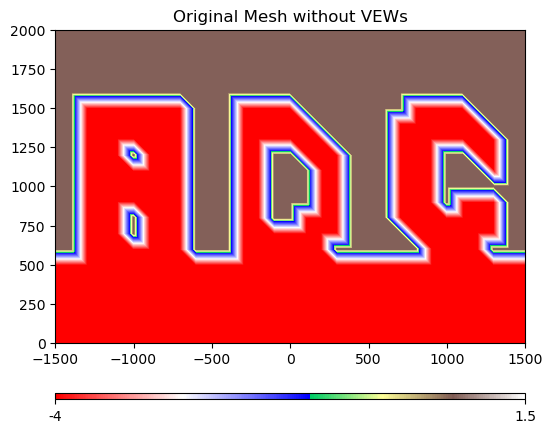

In [1]:
from adcircpy import AdcircMesh

# Load and plot the original mesh without VEWs
mesh = AdcircMesh.open('input/mesh_without_vews.14')
mesh.make_plot(title='Original Mesh without VEWs', vmin=-4, vmax=1.5)

Input polylines:

Text(0.5, 1.0, 'VEW Polylines')

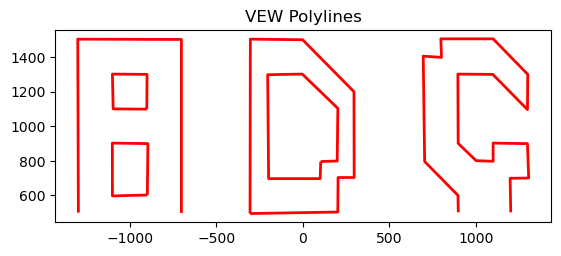

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read and plot the polylines
polylines = gpd.read_file('input/vew_polylines.shp')
ax = polylines.plot(color='red', linewidth=2)
plt.title('VEW Polylines')

Let's produce a vewstring yaml file:

In [3]:
# Execute polyline converter command
# python -m adcircutils.vewprocessing.polyline_converter input/mesh_without_vews.14 input/vew_polylines.shp -o output/vewstrings.yaml -n 0.03 -e 2.0
import subprocess

cmd = [
    'python', '-m', 'adcircutils.vewprocessing.polyline_converter',
    'input/mesh_without_vews.14',
    'input/vew_polylines.shp',
    '-o', 'output/vewstrings.yaml',
    '-n', '0.03',
    '-e', '2.0'
]
subprocess.run(cmd, check=True)



Successfully converted 6 polylines to VEW strings
VEW strings saved to: output/vewstrings.yaml


CompletedProcess(args=['python', '-m', 'adcircutils.vewprocessing.polyline_converter', 'input/mesh_without_vews.14', 'input/vew_polylines.shp', '-o', 'output/vewstrings.yaml', '-n', '0.03', '-e', '2.0'], returncode=0)

Resulting VEW strings:

In [4]:
# Print the contents of the vewstrings yaml file
with open('output/vewstrings.yaml', 'r') as f:
    print(f.read())

vewstrings:
- - node_id: 164
    x: -700.0
    y: 500.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 195
    x: -700.0
    y: 600.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 226
    x: -700.0
    y: 700.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 257
    x: -700.0
    y: 800.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 288
    x: -700.0
    y: 900.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 319
    x: -700.0
    y: 1000.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 350
    x: -700.0
    y: 1100.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 381
    x: -700.0
    y: 1200.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 412
    x: -700.0
    y: 1300.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 443
    x: -700.0
    y: 1400.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 474
    x: -700.0
    y: 1500.

## Step 2: Adding VEWs to the Mesh

Now we'll add the VEWs to the mesh using the node strings we created in the previous step. This process:
- Reads the original mesh
- Applies the VEW node strings
- Creates a new mesh with VEWs included

In [5]:
# Execute vew adder command
# python -m adcircutils.vewprocessing.vew_adder input/mesh_without_vews.14 output/vewstrings.yaml -o output/mesh_with_vews.14
import subprocess

cmd = [
    'python', '-m', 'adcircutils.vewprocessing.vew_adder',
    'input/mesh_without_vews.14',
    'output/vewstrings.yaml',
    '-o', 'output/mesh_with_vews.14'
]
subprocess.run(cmd, check=True)


Wrote mesh with VEW boundaries to output/mesh_with_vews.14


CompletedProcess(args=['python', '-m', 'adcircutils.vewprocessing.vew_adder', 'input/mesh_without_vews.14', 'output/vewstrings.yaml', '-o', 'output/mesh_with_vews.14'], returncode=0)

Resulting mesh with VEWs:

/home/sbunya/GitHub/adcircpy/adcircpy/figures.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wet_count = int(np.floor(colors * (float((values < 0.0).sum()) / float(values.size))))


<Axes: title={'center': 'Mesh with VEWs'}>

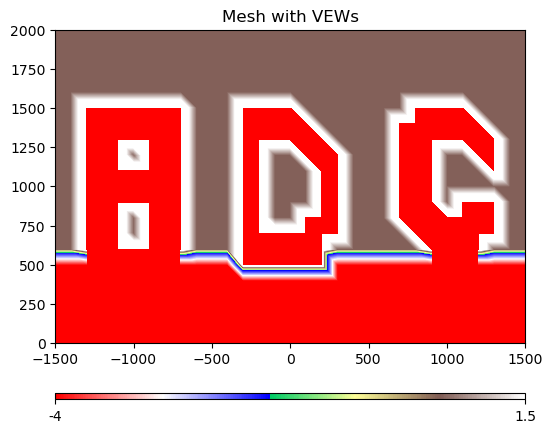

In [6]:
# Read and plot the mesh with VEWs
from adcircpy import AdcircMesh

mesh = AdcircMesh.open('output/mesh_with_vews.14')
mesh.make_plot(vmin=-4, vmax=1.5, title='Mesh with VEWs')

## Step 3: Scraping VEWs from the Mesh

Finally, we'll demonstrate how to extract VEW information from a mesh. This is useful for:
- Obtaining a mesh without VEWs before editing in a tool such as SMS and put the vewstings back using the `vew_adder`.
- Obtaining VEW strings before editing in some tool and put the vewstings back using the `vew_adder`.

The scraper will:
- Read the mesh with VEWs
- Extract all VEW information
- Save both a new mesh and a YAML file with the VEW data

In [7]:
# Execute vew scraper command
# python -m adcircutils.vewprocessing.vew_scraper output/mesh_with_vews.14 -o output/mesh_vews_scraped.14 -y output/vewstrings_scraped.yaml
import subprocess

cmd = [
    'python', '-m', 'adcircutils.vewprocessing.vew_scraper',
    'output/mesh_with_vews.14',
    '-o', 'output/mesh_vews_scraped.14',
    '-y', 'output/vewstrings_scraped.yaml'
]
subprocess.run(cmd, check=True)


CompletedProcess(args=['python', '-m', 'adcircutils.vewprocessing.vew_scraper', 'output/mesh_with_vews.14', '-o', 'output/mesh_vews_scraped.14', '-y', 'output/vewstrings_scraped.yaml'], returncode=0)

Resulting mesh wit VEWs removed:

/home/sbunya/GitHub/adcircpy/adcircpy/figures.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wet_count = int(np.floor(colors * (float((values < 0.0).sum()) / float(values.size))))


<Axes: title={'center': 'Mesh with VEWs Removed'}>

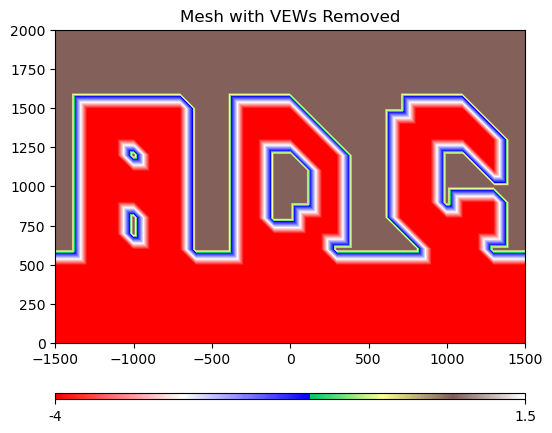

In [8]:
# Read and plot the scraped mesh
mesh = AdcircMesh.open('output/mesh_vews_scraped.14')
mesh.make_plot(vmin=-4, vmax=1.5, title='Mesh with VEWs Removed')

Resulting VEW strings YAML file:

In [9]:
# Print the contents of the YAML file
with open('output/vewstrings_scraped.yaml', 'r') as f:
    print(f.read())

vewstrings:
- - node_id: 164
    x: -700.0
    y: 500.0
    bank_elevation: -4.0
    bank_mannings_n: 0.03
  - node_id: 195
    x: -700.0
    y: 600.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 226
    x: -700.0
    y: 700.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 257
    x: -700.0
    y: 800.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 288
    x: -700.0
    y: 900.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 319
    x: -700.0
    y: 1000.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 350
    x: -700.0
    y: 1100.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 381
    x: -700.0
    y: 1200.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 412
    x: -700.0
    y: 1300.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 443
    x: -700.0
    y: 1400.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 474
    x: -700.0
    y: 1500

## Conclusion

This notebook has demonstrated the complete workflow for processing VEWs in ADCIRC meshes using the `adcircutils.vewprocessing` module. The process involves:

1. Converting VEW polylines to node strings in YAML format
2. Adding these VEWs to the mesh
3. Scraping off the VEWs